In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from copy import deepcopy

### Global Variables

In [40]:
epochs = 100
r_epochs = 2000 # num epochs for regularization
folds = 5
a = 0.25 # alpha for regularization
n_features = 87 # number of selected features after regularization
degree = 2 # polynomial degree

# local setup
dataset_path = '../../Datasets/Kaggle/Credit_Score'
output_path = dataset_path

# kaggle kernel setup
# dataset_path = '/kaggle/input/uwindsor-ai-club-can-credit-score-be-predicted'
# output_path = '/kaggle/working'

In [21]:
def load_data(data):
    df = pd.read_csv(data)
    return df

### Load Train and Test Data

kaggle link of the data : <br>
https://www.kaggle.com/competitions/uwindsor-ai-club-can-credit-score-be-predicted/data <br>
then download the <span style = "color : red">train.csv, test.csv and sample_submission.csv </span>

In [22]:
# read train and test data

train_data = load_data(f'{dataset_path}/train.csv')
test_data = load_data(f'{dataset_path}/test.csv')

# sample_submission = load_data(f'{dataset_path}/sample_submission.csv')

### Check Null values in Train and Test Data

In [23]:
train_data.isnull().sum()

CUST_ID                0
INCOME                 0
SAVINGS                0
DEBT                   0
R_SAVINGS_INCOME       0
                      ..
CAT_MORTGAGE           0
CAT_SAVINGS_ACCOUNT    0
CAT_DEPENDENTS         0
CREDIT_SCORE           0
DEFAULT                0
Length: 87, dtype: int64

In [24]:
# prints out the columns and the num of null values if any null value is found
print(f'\nTrain')
for i, val in enumerate(train_data.isnull().sum()):
    if(val > 0):
        print(f'col : {train_data.columns[i]}, val : {val}')
print(f'\nTest')
for i, val in enumerate(test_data.isnull().sum()):
    if(val > 0):
        print(f'col : {test_data.columns[i]}, val : {val}')


Train

Test


### Train and Test Splits

- Keeping the train_data for train and val
- Keeping the test_data for X_test only (y_test = CREDIT_SCORE column is not given, it should be predicted by us)
- Dropping **CUST_ID** from X_train and X_test 
- train_data -> X_train, y_train (90% of the train.csv) (After feature selection)
- test_data -> X_test (10% of the train.csv) (After feature selection) (y_test is not given)
- Check the shapes to verify correct formatting

In [25]:
# dividing the data into two parts : predictors, targets
X_train = train_data.drop(columns = ['CUST_ID', 'CREDIT_SCORE'], axis = 1)
y_train = train_data['CREDIT_SCORE']

X_test = test_data.drop('CUST_ID', axis = 1)

print(f'X_train.shape : {X_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'X_test.shape : {X_test.shape}')

X_train.shape : (700, 85)
y_train.shape : (700,)
X_test.shape : (300, 85)


In [26]:
# all the cols in the X_train
train_cols = X_train.columns
print(f'type(train_cols) : {type(train_cols)}')
print(f'Number of train_cols : {len(train_cols)}')
print(f'--------------------------------------------')
print(f'--------------------------------------------')

type(train_cols) : <class 'pandas.core.indexes.base.Index'>
Number of train_cols : 85
--------------------------------------------
--------------------------------------------


### Inspect Data before Preprocessing

<Axes: >

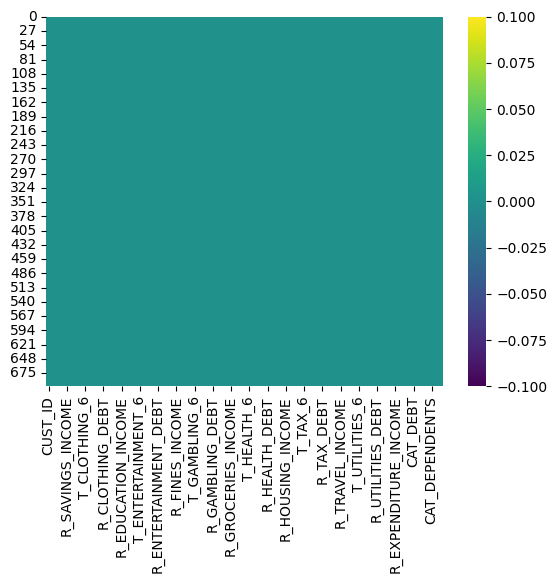

In [11]:
sns.heatmap(train_data.isnull(), cmap = 'viridis')

In [12]:
# for col_name, col_type in train_data.dtypes.items():
#     print(f'{col_name} -> {col_type}')

In [13]:
train_data['CAT_GAMBLING'].unique()

array(['High', 'No', 'Low'], dtype=object)

# Preprocessing

<br>

- From this part we will be working **Only** with **X_train, X_test** (instead of train_data, test_data)
- We have **CREDIT_SCORE** already separated
- X_train and X_test do not have **CUST_ID** (Not a feature, so dropped it while forming X_train, X_test) 
- Convert the categorical col **CAT_GAMBLING** into 2 numerical dummy cols
- Find columns which are highly correlated to one another and drop any one of them (pruning)
- **CUST_ID** will be joined with y_pred after prediction 

In [27]:
from itertools import combinations

dummy_cols = pd.get_dummies(X_train['CAT_GAMBLING'], dtype = int, drop_first = True)
dummy_cols_test = pd.get_dummies(X_test['CAT_GAMBLING'], dtype = int, drop_first = True)

X_train = pd.concat([X_train.drop(columns = ['CAT_GAMBLING']), dummy_cols], axis = 1)
X_test = pd.concat([X_test.drop(columns = ['CAT_GAMBLING']), dummy_cols_test], axis = 1)

columns_to_drop = []

for c1, c2 in combinations(X_train.columns, 2):
    if X_train[c1].corr(X_train[c2]) > 0.9:
#         print(f'c1 : {c1}, c2 : {c2}, corr = {X_train[c1].corr(X_train[c2])}')
        columns_to_drop.append(c2)
columns_to_drop

X_train.drop(columns = columns_to_drop, inplace = True, axis = 1)
X_test.drop(columns = columns_to_drop, inplace = True, axis = 1)

# Initial cols = 87
# Removed CUST_ID, CREDIT_SCORE -> 85
# Replaced CAT_GAMLING with 2 int cols -> 86
print(f'X_train.cols : {len(X_train.columns)}')
print(f'X_test.cols : {len(X_test.columns)}')

# test whether the current data is in the correct shape
print(f'\nX_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_train tail columns : {X_train.columns[-1:-5:-1]}')
print(f'\nX_test : {X_test.shape}')
print(f'X_test tail columns : {X_test.columns[-1:-5:-1]}')

X_train.cols : 68
X_test.cols : 68

X_train : (700, 68), y_train : (700,)
X_train tail columns : Index(['No', 'Low', 'DEFAULT', 'CAT_DEPENDENTS'], dtype='object')

X_test : (300, 68)
X_test tail columns : Index(['No', 'Low', 'DEFAULT', 'CAT_DEPENDENTS'], dtype='object')


### Baselines
### ...........................................................

### LinearRegression

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
nmse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv = folds)
mean_rmse = np.mean(np.sqrt(-nmse))

print(f'LR mean rmse = {mean_rmse}')

LR mean rmse = 28.282737031917044


### Ridge Regression

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
params = {'ridge__alpha' : [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge)
])
rr = GridSearchCV(pipeline, params, scoring = 'neg_mean_squared_error', cv = folds)
rr.fit(X_train, y_train)

# best params
a = rr.best_params_
nmse = rr.best_score_
rmse = np.sqrt(-nmse)

print(f'RR best alpha = {a}')
print(f'RR rmse = {rmse}')

RR best alpha = {'ridge__alpha': 10}
RR rmse = 28.28696034001431


### Lasso Regression

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_regressor = Lasso(tol = 0.01)
params = {'lasso__alpha' : [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100, 200, 500]}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', lasso_regressor)
])
lasso_regressor = GridSearchCV(pipeline, params, scoring = 'neg_mean_squared_error', cv = folds)
lasso_regressor.fit(X_train, y_train)

# best params
a = lasso_regressor.best_params_
nmse = lasso_regressor.best_score_
rmse = np.sqrt(-nmse)

print(f'lasso_regressor best alpha = {a}')
print(f'lasso_regressor rmse = {rmse}')

C:\Users\Jamil\anaconda3\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+05, tolerance: 1.845e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil\anaconda3\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+05, tolerance: 1.858e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil\anaconda3\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

lasso_regressor best alpha = {'lasso__alpha': 1}
lasso_regressor rmse = 28.03895969320706


### XGBoost


In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Create an XGBoost regressor model
xgb = XGBRegressor()

# Best parameters: {'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.05, 'lambda': 20, 'booster': 'gbtree'}

# pass 2
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5, 10],
    'booster' : ['gbtree'],
    'min_child_weight': [1, 2, 3, 4, 5],
    'lambda' : [0.1, 0.5, 1, 5, 10, 20, 30],
    'n_estimators': [50, 100, 250, 500, 1000, 1500]
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error', cv=folds)
random_search.fit(X_train, y_train)

# Get the best parameters and RMSE score
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)


Best parameters: {'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.1, 'lambda': 5, 'booster': 'gbtree'}
Best RMSE: 29.50043841989629


### Experimental Model Section

To test the model drafts here (The data preprocessing should be done beforehand)

In [50]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define your neural network architecture
def create_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Define function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = create_model(X_train.shape[1])
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    return test_loss

# Assume your data is X and y

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True)

test_losses = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_loss = train_and_evaluate_model(X_train, y_train, X_test, y_test)
    test_losses.append(test_loss)

# Compute average test loss
avg_test_loss = np.mean(test_losses)
print(f'Average test loss across 10 folds: {avg_test_loss:.4f}')

AttributeError: module 'keras.src' has no attribute 'utils'

### Baseline Results

| ID | Model | Degree | Epochs | Regularization | Reg Epochs, Tol | Lambda | N_features | Folds | RMSE |
| --- | ---- | -------- | ----- | -------------- | ----- | ------ | ----- | ---- | ---- |
| 1 | lr | 1 | None | None | None | 0 | All | 0 | **24.86964904316159** |
| 2 | lr | 1 | None | L2 | X | 20 | X | 10 | 28.506133250715063 |
| 3 | lr | 1 | None | None | None | 0 | 86 | 10 | **29.18143127944806** |
| 4 | lr | 1 | None | L1 | 1000 | 1 | X | 10 | 27.67585141705469 | 
| 5 | lr | 1 | None | L1 | 10000, 0.01 | 1 | X | 10 | 27.666622998342643 |
| 6 | lr | 2 | None | L2 | 2000 | 100 | X | 10 | 44.09927407811474 | 
| 7 | lr | 1 | None | L2 | 2000 | 20 | 68 (Correlation drop off) | 10 | 28.353964603124588 |
| 8 | lr | 1 | None | L2 | 2000 | 1 | 68 | 10 | **27.617890371610304** |
| 8 | lr | 1 | None | L2 | 2000 | 1 | 68 | 10 | X |

### Build the Best Model

Select the best model from the grid_search or random_search's best_params and then create the model before prediction

# Prediction

In [17]:
print(f'X_test.shape : {X_test.shape}')

# predict
# y_test = rr.predict(X_test)
y_test = lasso_regressor.predict(X_test)

test_data_output = pd.DataFrame({'CUST_ID' : test_data['CUST_ID'], 'CREDIT_SCORE' : y_test})

print(f'test_data_output.columns : {test_data_output.columns}')
print(f'test_data_output.shape : {test_data_output.shape}')

X_test.shape : (300, 68)
test_data_output.columns : Index(['CUST_ID', 'CREDIT_SCORE'], dtype='object')
test_data_output.shape : (300, 2)


### Save Output for Submission

In [18]:
test_data_output.to_csv(f'{output_path}/submission_id8.csv', index = False)